In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import nibabel as nib

In [2]:

def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    return axs


In [3]:
dcm_img=pydicom.dcmread('Data/Sag_FLAIR+FATSAT_CUBE_3/IM-0021-0071.dcm')

In [4]:
dcm_img_data = dcm_img.pixel_array

In [5]:
dcm_img_data.shape

(256, 256)

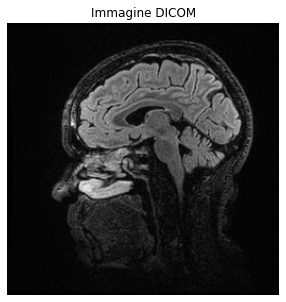

In [6]:
axes = plot_images([dcm_img_data],labels=['Immagine DICOM'])

In [14]:
def window(image, lower_threshold, upper_threshold):
    """
    Funzione che calcola la finestratura della dinamica di input
    per mapparla in [0 - 255]
    """
    
    # Saturiamo le soglie se sono fuori range rispetto all'immagine di ingresso
    if lower_threshold < np.min(image):
        lower_threshold = np.min(image)

    if upper_threshold > np.max(image):
        upper_threshold = np.max(image)

    # Creiamo la nuova immagine riempita di 1
    new_image = np.full_like(image, 1)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            # Applichiamo la trasformazione puntualmente
            new_image[i, j] = 0 if image[i, j] < lower_threshold \
                else 255 if image[i, j] > upper_threshold \
                else int(255*(image[i, j] - lower_threshold)/(upper_threshold - lower_threshold))

    return new_image



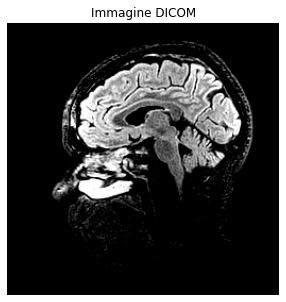

In [15]:
def window_and_plot(image, lower, upper):
    """
    Funzione wrapper per l'applicazione della trasformazione
    """
    dcm_img_transformed = window(image,lower,upper)

    plot_images([dcm_img_transformed],labels=['Immagine DICOM'])

window_and_plot(dcm_img_data,100,400)


In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, clear_output


def transform_image(image):
    """
    Funzione wrapper per utilizzo dell'interfaccia utente grafica
    su un'immagine qualsiasi
    """
    # estremi per la variazione degli slider
    minimum = np.min(image)
    maximum = np.max(image)

    w=interactive(window_and_plot,\
        image=fixed(image),\
        upper=widgets.IntSlider(min=minimum,max=maximum,value=250,continuous_update=True),\
        lower=widgets.IntSlider(min=minimum,max=maximum,value=50,continuous_update=True)\
        )

    display(w)

In [17]:
%matplotlib inline
transform_image(dcm_img_data)

interactive(children=(IntSlider(value=50, description='lower', max=690), IntSlider(value=250, description='upp…

In [18]:
import os
import os.path

def load_dcm_volume(directory):
    """
    Funzione che carica un volume di dati DICOM da una cartella
    assumendo che questa contenga solamente un insieme di file .dcm
    """

    # leggiamo la lista dei file nella cartella
    files = os.listdir(directory)
    files.sort()
    
    # leggiamo il primo file per ottenere le dimensioni e il tipo della singola slice
    file = pydicom.dcmread(f'{directory}/{files[0]}')
    
    # creiamo il volume
    volume = np.full((len(files),file.pixel_array.shape[0],file.pixel_array.shape[1]),\
                    1,dtype=file.pixel_array.dtype)

    # carichiamo la prima slice, già letta, e successivamente le altre 
    volume[0,:,:] = file.pixel_array

    for i in range(1,len(files)):
        volume[i,:,:] = pydicom.dcmread(f'{directory}/{files[i]}').pixel_array
    
    return volume


In [19]:
dcm_volume = load_dcm_volume('Data/Sag_FLAIR+FATSAT_CUBE_3')